In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
from aplpy import FITSFigure  
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 18})
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
%matplotlib widget
from PIL import Image


In [14]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid
    
def lin_fit(x, a, b):
    return a + b*x

def DoubleParamFunc(X, a, b, c):
    x,y = X
    return a + b*x + c*y

def binning_data(array1,array2,delt):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
    plt.figure(figsize=(10,6))
    plt.scatter(levels_centres,binned_data)


def curve_fitting(x):
    param, param_cov = curve_fit(DoubleParamFunc,(x[:,2],x[:,1]),x[:,0])
    return param


def remove_nan(array1,array2):
    selector = ~np.isnan(array1)
    array1_fil = array1[selector]
    array2_fil = array2[selector]

    selector = ~np.isnan(array2_fil)
    array1_fil = array1_fil[selector]
    array2_fil = array2_fil[selector]
    return array1_fil,array2_fil

def binning_datav1(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    plt.figure(figsize=(12,8))
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,c='k')

def binning_datav2(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    # plt.figure(figsize=(10,6))
    plt.errorbar(10**levels_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**levels_centres,10**binned_data,s = 40,c='r')
    plt.plot(10**levels_centres,10**binned_data,c='k')

def binning_datav3(array1,array2,delt_bin):
    levels = np.linspace(np.nanmin(array1),np.nanmax(array1),delt_bin)
    levels_centres = (levels[:-1] + levels[1:])/2
    binned_data = []
    error_bar = []
    for i in range(levels.shape[0]-1):
        temp_array2 = array2.copy()
        Selector = array1 < levels[i]
        temp_array2[Selector] = np.nan
        Selector =  array1 > levels[i+1]
        temp_array2[Selector] =np.nan
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))
    level_bins = np.linspace(np.amin(levels_centres),np.amax(levels_centres),10)
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)
    levels_centres = np.array(levels_centres)
    param, PS_param_cov = curve_fit(lin_fit, levels_centres, binned_data,sigma=error_bar)
    PS_FitFunc = lin_fit(level_bins,param[0],param[1])
    return param,level_bins,PS_FitFunc


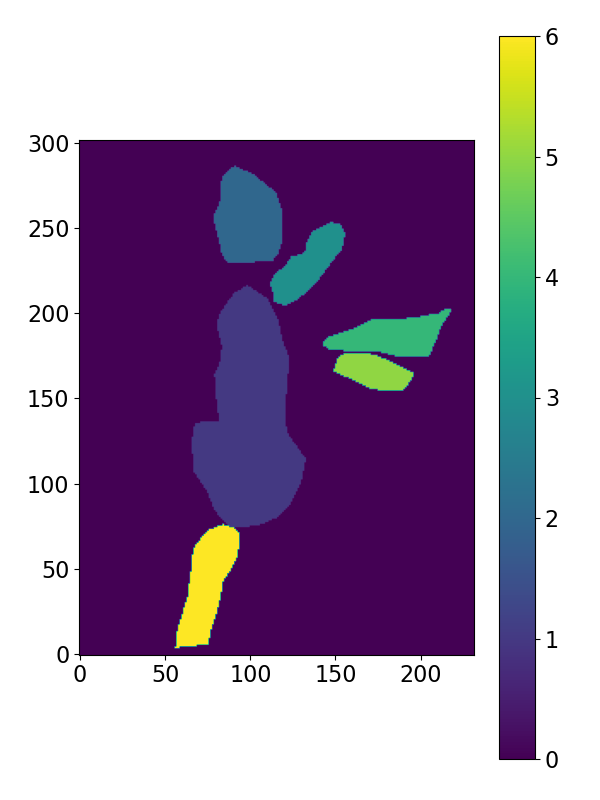

In [15]:
########## importing and testing the file
FITS1 = '../FITS_file/new_fits/DR21_OTF_full_pipeline.fits'
FITS2 = '../FITS_file/new_fits/DR21_full_NH2_Repr.fits'
FITS3 = '../FITS_file/new_fits/DR21_full_Tdust_Repr.fits'
FITS4 = '../FITS_file/new_fits/DR21_full_IRAC4_Repr.fits'
FITS5 = '../FITS_file/new_fits/DR21_full_Her250_Repr.fits'
FITS6 = '../FITS_file/new_fits/DR21_full_Fil_Mask.fits'

hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
hdul6 = fits.open(FITS6)

# print(hdul.info())

MapStokesI = hdul[0]
MapStokesIError = hdul[1]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]
Mask = hdul6[0]

MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()



######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan



############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############ removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan

# plt.figure(figsize=(6,6))
# plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)

BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)

############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

plt.figure(figsize=(6,8))

plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)
plt.imshow(Mask.data,origin='lower')
plt.colorbar()
plt.tight_layout()
plt.show()


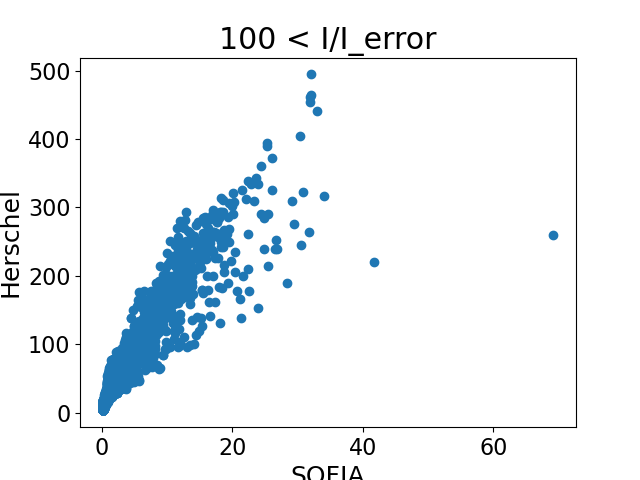

In [16]:
sofia_data = BlankedMapStokesI.data.flatten()
herschel_data = BlankedMapHer250.data.flatten()

x = np.linspace(np.nanmin(sofia_data),np.nanmax(sofia_data),10)
y = x
plt.figure()
plt.scatter(sofia_data,herschel_data)
# plt.plot(x,y)
plt.title('100 < I/I_error')
plt.xlabel('SOFIA')
plt.ylabel('Herschel')
plt.show()

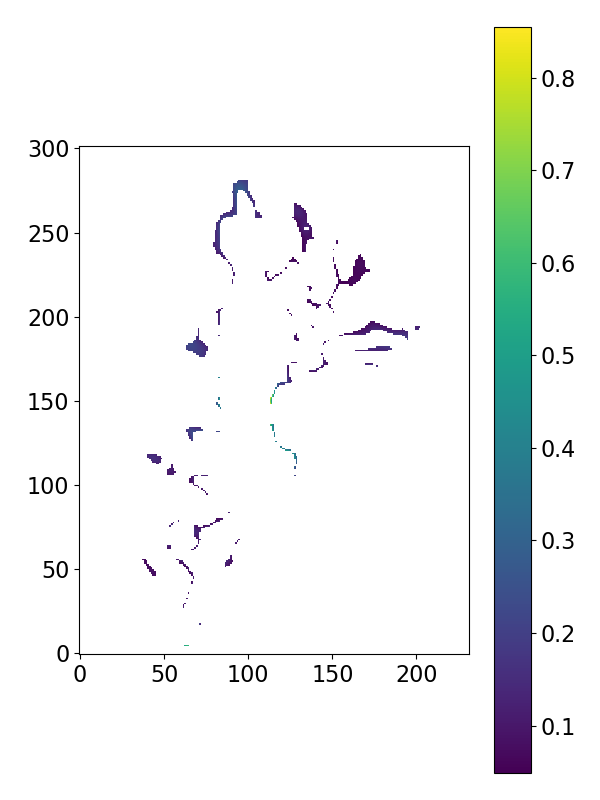

In [17]:
########## importing and testing the file
FITS1 = '../FITS_file/new_fits/DR21_OTF_full_pipeline.fits'
FITS2 = '../FITS_file/new_fits/DR21_full_NH2_Repr.fits'
FITS3 = '../FITS_file/new_fits/DR21_full_Tdust_Repr.fits'
FITS4 = '../FITS_file/new_fits/DR21_full_IRAC4_Repr.fits'
FITS5 = '../FITS_file/new_fits/DR21_full_Her250_Repr.fits'
FITS6 = '../FITS_file/new_fits/DR21_full_Fil_Mask.fits'

hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
hdul6 = fits.open(FITS6)

# print(hdul.info())

MapStokesI = hdul[0]
MapStokesIError = hdul[1]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]
Mask = hdul6[0]

MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()



######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan



############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############ removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data > 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan

Selector = MapStokesI.data/MapStokesIError.data < 50
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan

# plt.figure(figsize=(6,6))
# plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)

BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)

############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

plt.figure(figsize=(6,8))

plt.imshow(BlankedMapStokesI.data,origin='lower')
# plt.imshow(Mask.data,origin='lower')
plt.colorbar()
plt.tight_layout()
plt.show()


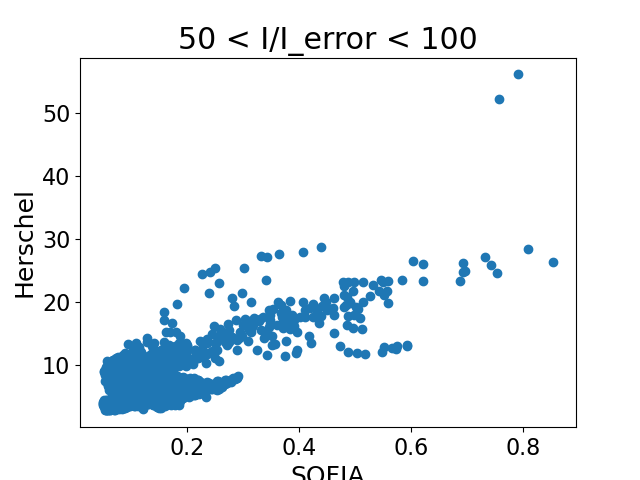

In [18]:
sofia_data = BlankedMapStokesI.data.flatten()
herschel_data = BlankedMapHer250.data.flatten()

x = np.linspace(np.nanmin(sofia_data),np.nanmax(sofia_data),10)
y = x
plt.figure()
plt.scatter(sofia_data,herschel_data)
# plt.plot(x,y)
plt.title('50 < I/I_error < 100')
plt.xlabel('SOFIA')
plt.ylabel('Herschel')
plt.show()

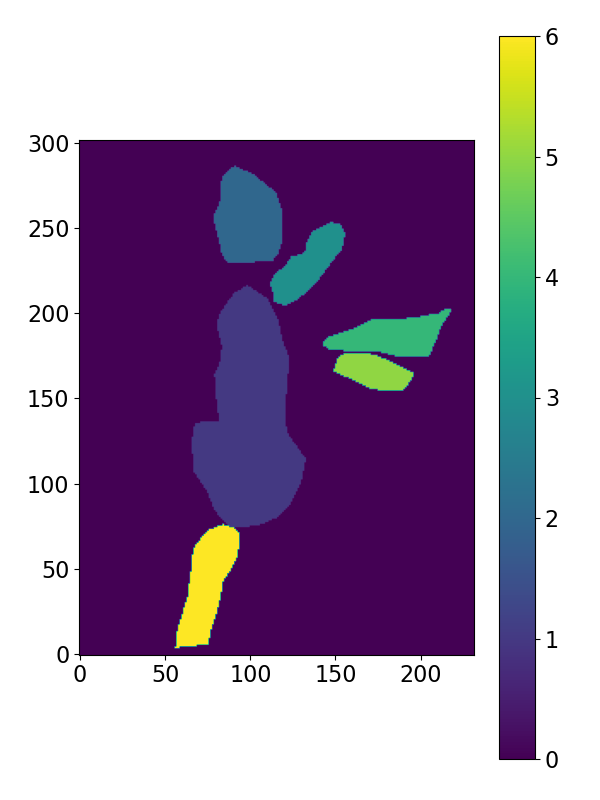

In [19]:
########## importing and testing the file
FITS1 = '../FITS_file/new_fits/DR21_OTF_full_pipeline.fits'
FITS2 = '../FITS_file/new_fits/DR21_full_NH2_Repr.fits'
FITS3 = '../FITS_file/new_fits/DR21_full_Tdust_Repr.fits'
FITS4 = '../FITS_file/new_fits/DR21_full_IRAC4_Repr.fits'
FITS5 = '../FITS_file/new_fits/DR21_full_Her250_Repr.fits'
FITS6 = '../FITS_file/new_fits/DR21_full_Fil_Mask.fits'

hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
hdul6 = fits.open(FITS6)

# print(hdul.info())

MapStokesI = hdul[0]
MapStokesIError = hdul[1]
MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]
Mask = hdul6[0]

MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()



######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data


Selector = (MapPolSNR.data < 3)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan



############## removing any points with pfrac above 50
Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan


############ removing any data points with I/I_error < 100
Selector = MapStokesI.data/MapStokesIError.data < 100
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapHer250.data[Selector] = np.nan

# plt.figure(figsize=(6,6))
# plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)

BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)

############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

plt.figure(figsize=(6,8))

plt.imshow(np.log10(MapHer250.data),origin='lower',vmin = 0 , vmax = 3)
plt.imshow(Mask.data,origin='lower')
plt.colorbar()
plt.tight_layout()
plt.show()


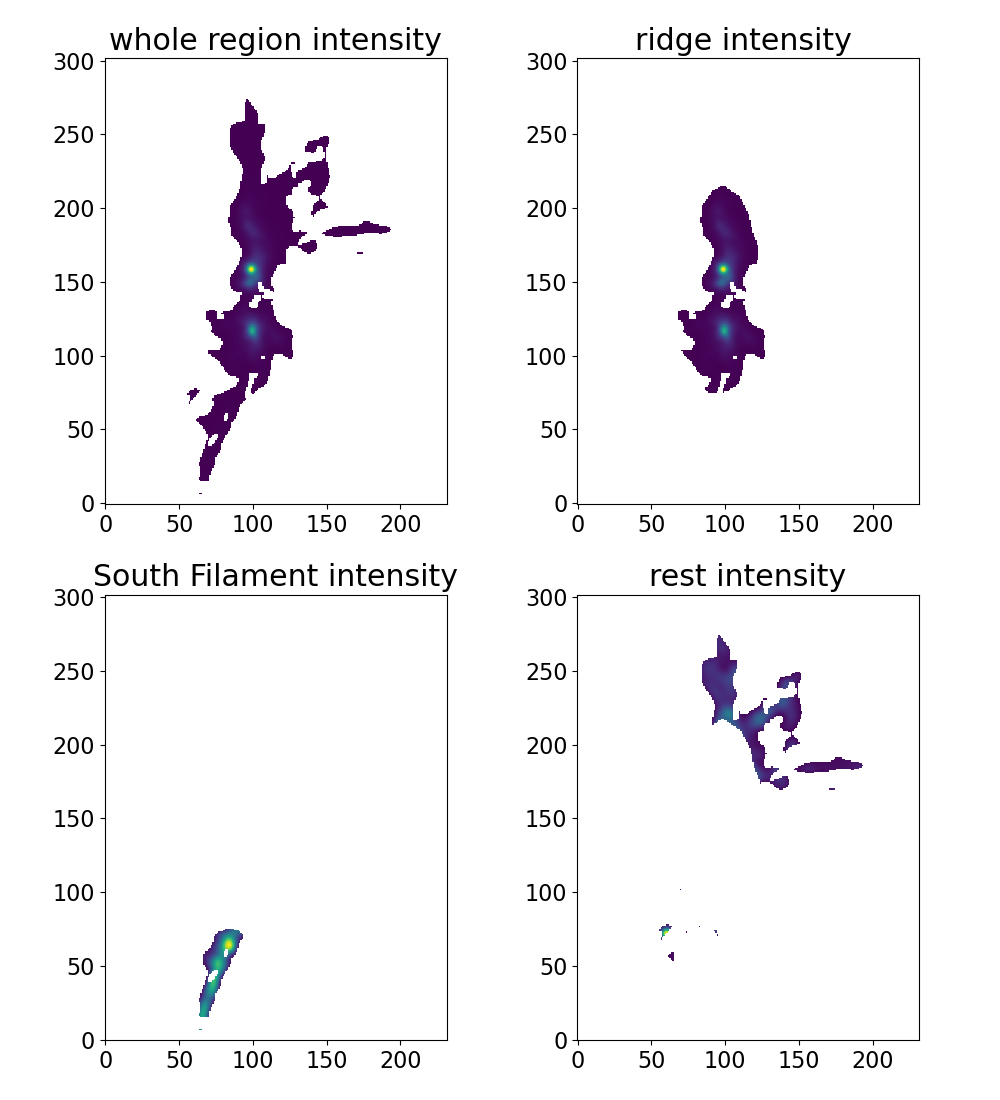

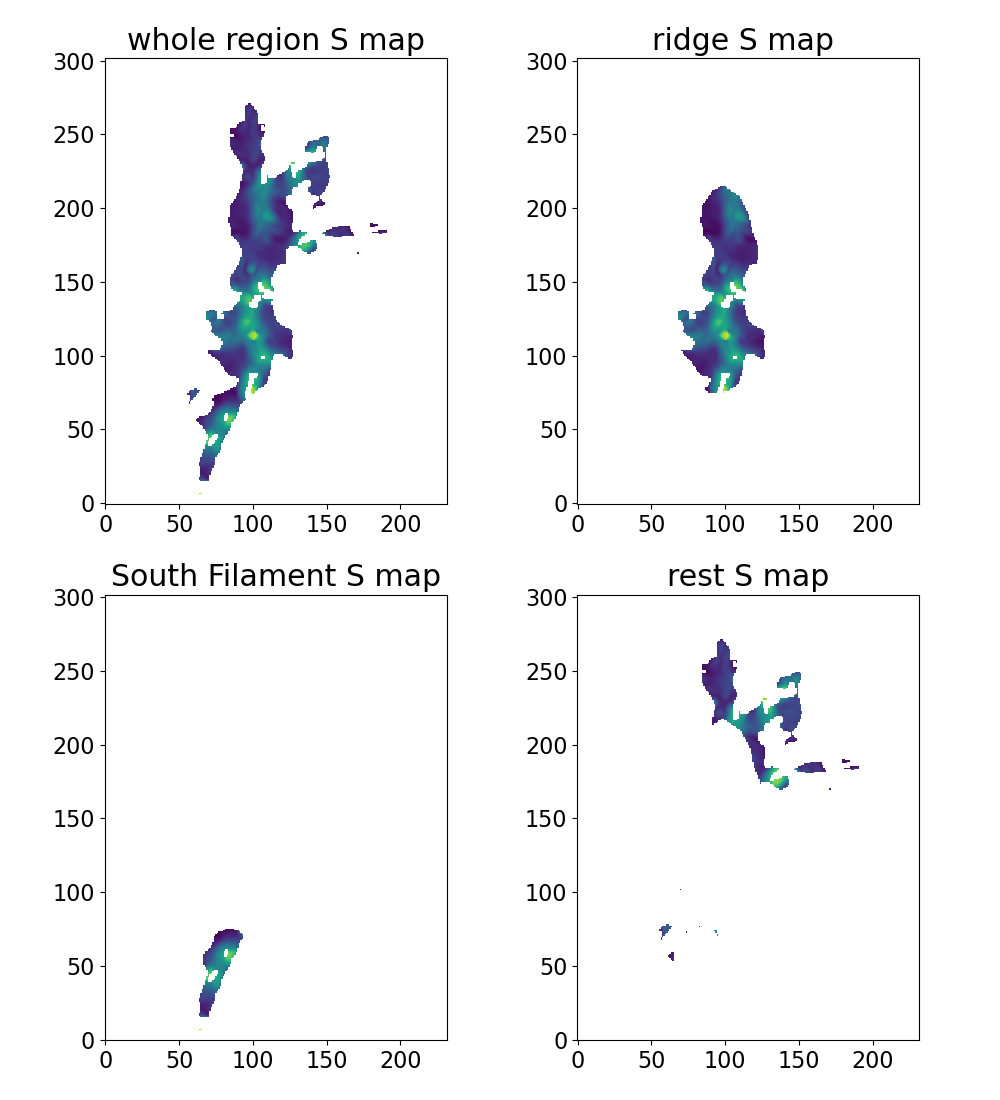

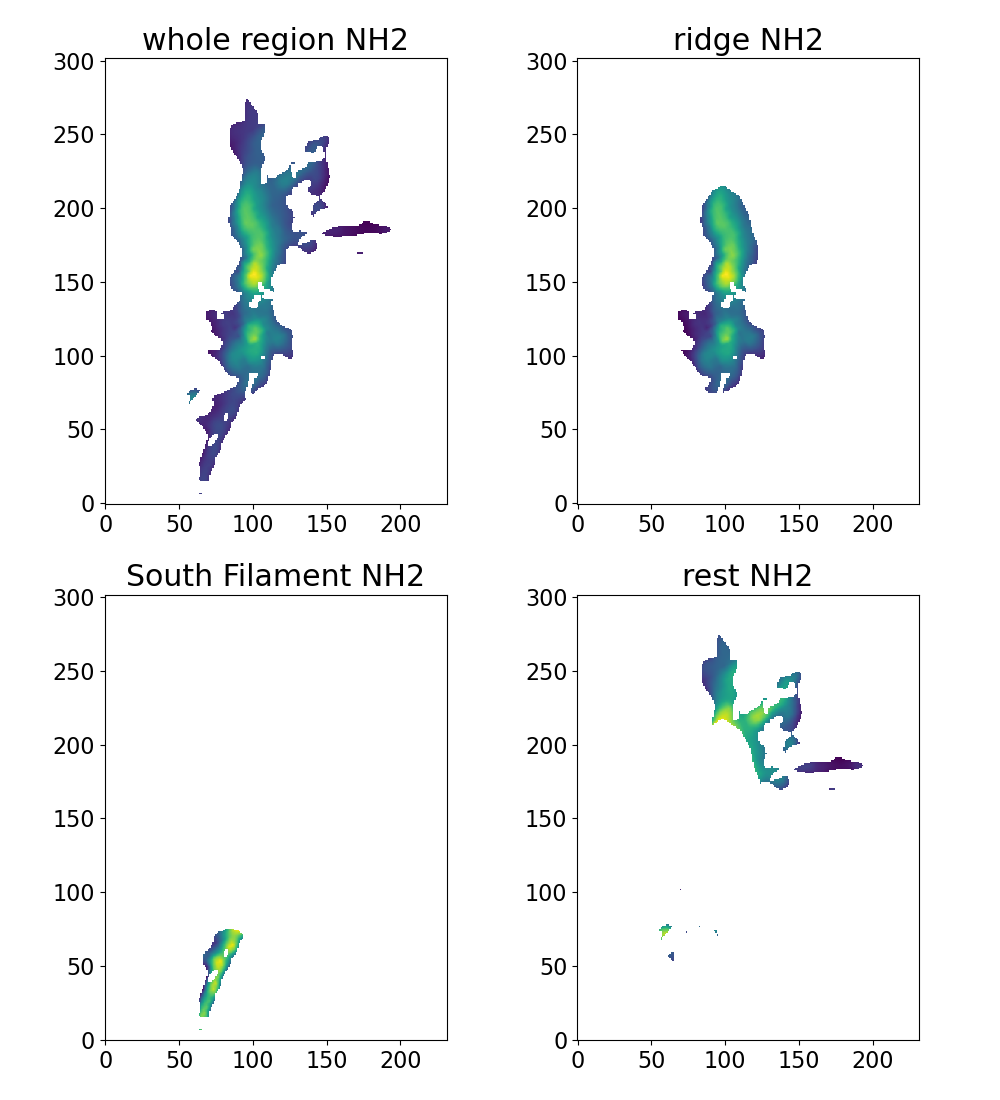

C:\Users\DELL\AppData\Local\Temp\ipykernel_8044\27653532.py:106: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(BlankedMap8Mircon.data),origin='lower')
C:\Users\DELL\AppData\Local\Temp\ipykernel_8044\27653532.py:109: RuntimeWarning: invalid value encountered in log10
  ax2.imshow(np.log10(micron8_ridge.data),origin = 'lower')


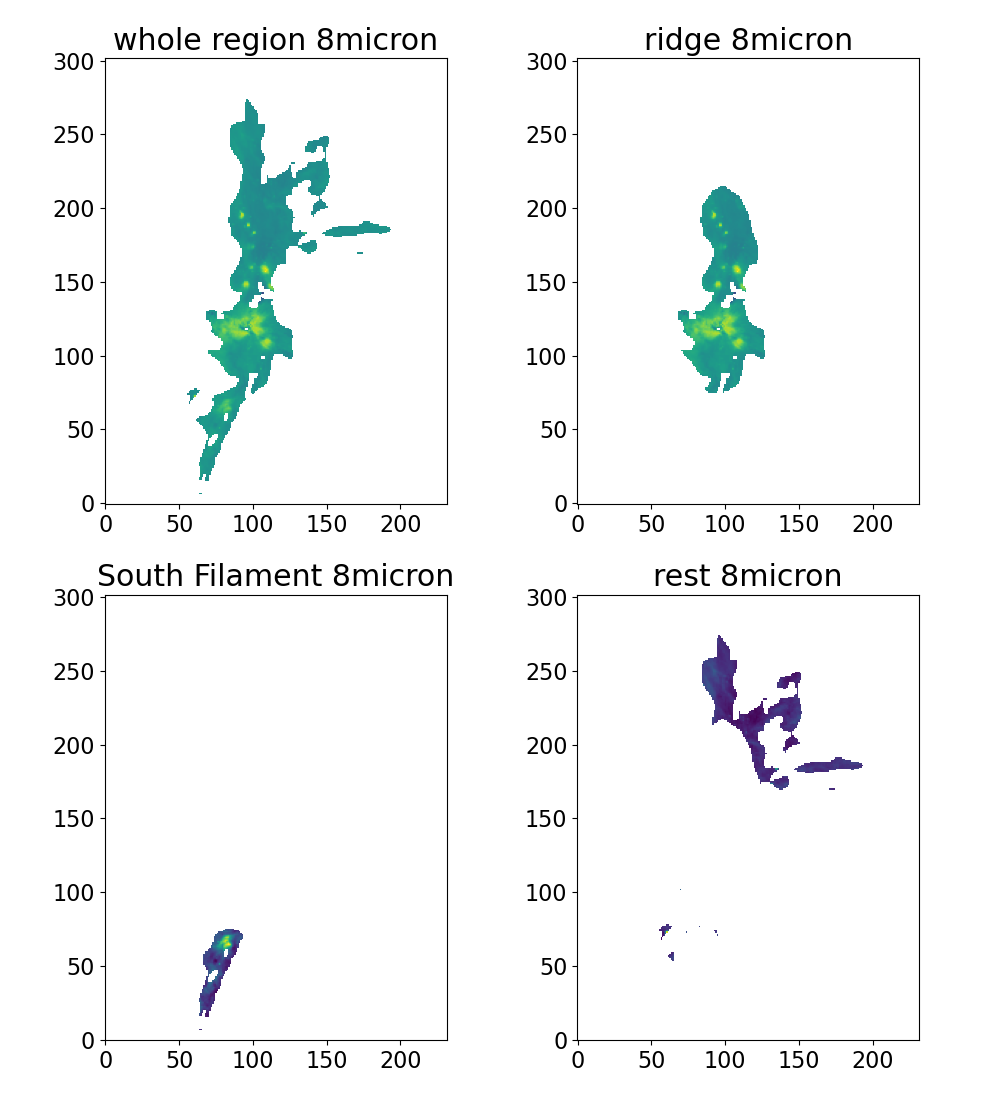

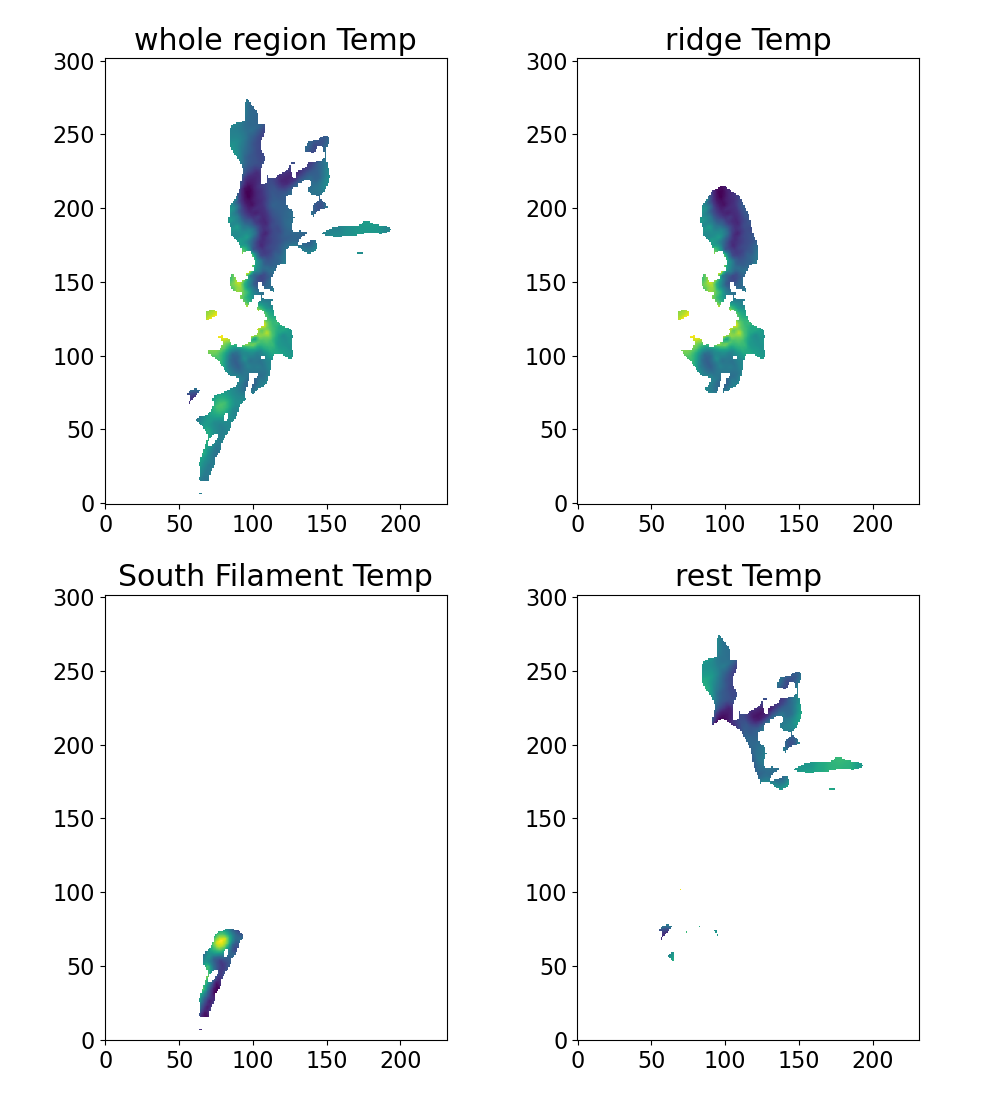

In [20]:
hdu = fits.open('../Internship-MIT/S_map.fits')[1]
S_map_deb = hdu



I_ridge = BlankedMapStokesI.copy()
p_ridge = BlankedMapPol.copy()
s_ridge = S_map_deb.copy()
nh2_ridge = BlankedMapColumnDensity.copy()
micron8_ridge = BlankedMap8Mircon.copy()
temp_ridge = BlankedMapTemperature.copy()

I_SouthFilament = BlankedMapStokesI.copy()
p_SouthFilament = BlankedMapPol.copy()
s_SouthFilament = S_map_deb.copy()
nh2_SouthFilament = BlankedMapColumnDensity.copy()
micron8_SouthFilament = BlankedMap8Mircon.copy()
temp_SouthFilament = BlankedMapTemperature.copy()


I_rest = BlankedMapStokesI.copy()
p_rest = BlankedMapPol.copy()
s_rest = S_map_deb.copy()
nh2_rest = BlankedMapColumnDensity.copy()
micron8_rest = BlankedMap8Mircon.copy()
temp_rest = BlankedMapTemperature.copy()

Selector = Mask.data != 1
I_ridge.data[Selector] = np.nan
p_ridge.data[Selector] = np.nan
s_ridge.data[Selector] = np.nan
nh2_ridge.data[Selector] = np.nan
micron8_ridge.data[Selector] = np.nan
temp_ridge.data[Selector] = np.nan

Selector = (Mask.data == 1) + (Mask.data == 6)
I_rest.data[Selector] = np.nan 
p_rest.data[Selector] = np.nan
s_rest.data[Selector] = np.nan
nh2_rest.data[Selector] = np.nan
micron8_rest.data[Selector] = np.nan
temp_rest.data[Selector] = np.nan

Selector = Mask.data != 6
I_SouthFilament.data[Selector] = np.nan 
p_SouthFilament.data[Selector] = np.nan
s_SouthFilament.data[Selector] = np.nan
nh2_SouthFilament.data[Selector] = np.nan
micron8_SouthFilament.data[Selector] = np.nan
temp_SouthFilament.data[Selector] = np.nan





fig = plt.subplots(figsize =(10,11))
ax1 = plt.subplot(221)
ax1.imshow(BlankedMapStokesI.data,origin='lower')
ax1.set_title('whole region intensity')
ax2 = plt.subplot(222)
ax2.imshow(I_ridge.data,origin = 'lower')
ax2.set_title('ridge intensity ')
ax3 = plt.subplot(223)
ax3.imshow(I_SouthFilament.data,origin = 'lower')
ax3.set_title('South Filament intensity')
ax4 = plt.subplot(224)
ax4.imshow(I_rest.data,origin = 'lower')
ax4.set_title('rest intensity')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(10,11))
ax1 = plt.subplot(221)
ax1.imshow(S_map_deb.data,origin='lower')
ax1.set_title('whole region S map')
ax2 = plt.subplot(222)
ax2.imshow(s_ridge.data,origin = 'lower')
ax2.set_title('ridge S map ')
ax3 = plt.subplot(223)
ax3.imshow(s_SouthFilament.data,origin = 'lower')
ax3.set_title('South Filament S map')
ax4 = plt.subplot(224)
ax4.imshow(s_rest.data,origin = 'lower')
ax4.set_title('rest S map')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(10,11))
ax1 = plt.subplot(221)
ax1.imshow(np.log10(BlankedMapColumnDensity.data),origin='lower')
ax1.set_title('whole region NH2')
ax2 = plt.subplot(222)
ax2.imshow(np.log10(nh2_ridge.data),origin = 'lower')
ax2.set_title('ridge NH2')
ax3 = plt.subplot(223)
ax3.imshow(np.log10(nh2_SouthFilament.data),origin = 'lower')
ax3.set_title('South Filament NH2')
ax4 = plt.subplot(224)
ax4.imshow(np.log10(nh2_rest.data),origin = 'lower')
ax4.set_title('rest NH2')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(10,11))
ax1 = plt.subplot(221)
ax1.imshow(np.log10(BlankedMap8Mircon.data),origin='lower')
ax1.set_title('whole region 8micron')
ax2 = plt.subplot(222)
ax2.imshow(np.log10(micron8_ridge.data),origin = 'lower')
ax2.set_title('ridge 8micron')
ax3 = plt.subplot(223)
ax3.imshow(np.log10(micron8_SouthFilament.data),origin = 'lower')
ax3.set_title('South Filament 8micron')
ax4 = plt.subplot(224)
ax4.imshow(np.log10(micron8_rest.data),origin = 'lower')
ax4.set_title('rest 8micron')
plt.tight_layout()
plt.show()

fig = plt.subplots(figsize =(10,11))
ax1 = plt.subplot(221)
ax1.imshow(np.log10(BlankedMapTemperature.data),origin='lower')
ax1.set_title('whole region Temp')
ax2 = plt.subplot(222)
ax2.imshow(np.log10(temp_ridge.data),origin = 'lower')
ax2.set_title('ridge Temp')
ax3 = plt.subplot(223)
ax3.imshow(np.log10(temp_SouthFilament.data),origin = 'lower')
ax3.set_title('South Filament Temp')
ax4 = plt.subplot(224)
ax4.imshow(np.log10(temp_rest.data),origin = 'lower')
ax4.set_title('rest Temp')
plt.tight_layout()
plt.show()


In [21]:
def binning_equal_width(array1,array2,Nbins):
    filtered1,filtered2 = remove_nan(array1,array2)
    bins = np.linspace(np.nanmin(filtered1),np.nanmax(filtered1),Nbins)
    # bin_centres = (bins[:-1] + bins[1:])/2

    bin_centres = []
    binned_data = []
    error_bar = []

    for i in range(0,(bins.shape[0]-1)):
        temp_array1 = filtered1.copy()
        temp_array2 = filtered2.copy()

        Selector = filtered1 < bins[i]
        temp_array1[Selector] = np.nan
        temp_array2[Selector] = np.nan
        Selector =  filtered1 > bins[i+1]
        temp_array1[Selector] = np.nan
        temp_array2[Selector] = np.nan
        bin_centres.append(np.nanmean(temp_array1))
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))

    bin_centres = np.array(bin_centres)
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)


    plt.errorbar(10**bin_centres,10**binned_data,yerr=error_bar,c='grey')
    plt.scatter(10**bin_centres,10**binned_data,s = 40,c='k')
    plt.plot(10**bin_centres,10**binned_data,c='k')


def binning_equal_width_fits(array1,array2,Nbins):
    filtered1,filtered2 = remove_nan(array1,array2)
    bins = np.linspace(np.nanmin(filtered1),np.nanmax(filtered1),Nbins)
    # bin_centres = (bins[:-1] + bins[1:])/2

    bin_centres = []
    binned_data = []
    error_bar = []

    for i in range(0,(bins.shape[0]-1)):
        temp_array1 = filtered1.copy()
        temp_array2 = filtered2.copy()

        Selector = filtered1 < bins[i]
        temp_array1[Selector] = np.nan
        temp_array2[Selector] = np.nan
        Selector =  filtered1 > bins[i+1]
        temp_array1[Selector] = np.nan
        temp_array2[Selector] = np.nan
        bin_centres.append(np.nanmean(temp_array1))
        binned_data.append(np.nanmean(temp_array2))
        error_bar.append(np.nanstd(10**temp_array2))


    bin_centres = np.array(bin_centres)
    binned_data = np.array(binned_data)
    error_bar = np.array(error_bar)

    level_bins = np.linspace(np.amin(bin_centres),np.amax(bin_centres),10)
    param, PS_param_cov = curve_fit(lin_fit, bin_centres, binned_data)
    PS_FitFunc = lin_fit(level_bins,param[0],param[1])
    return param,10**level_bins,10**PS_FitFunc



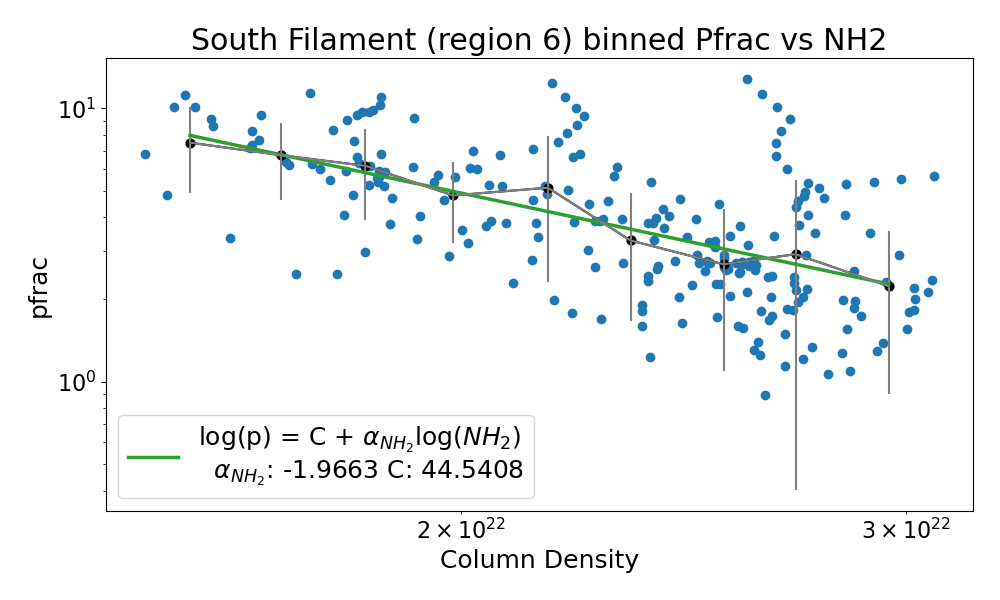

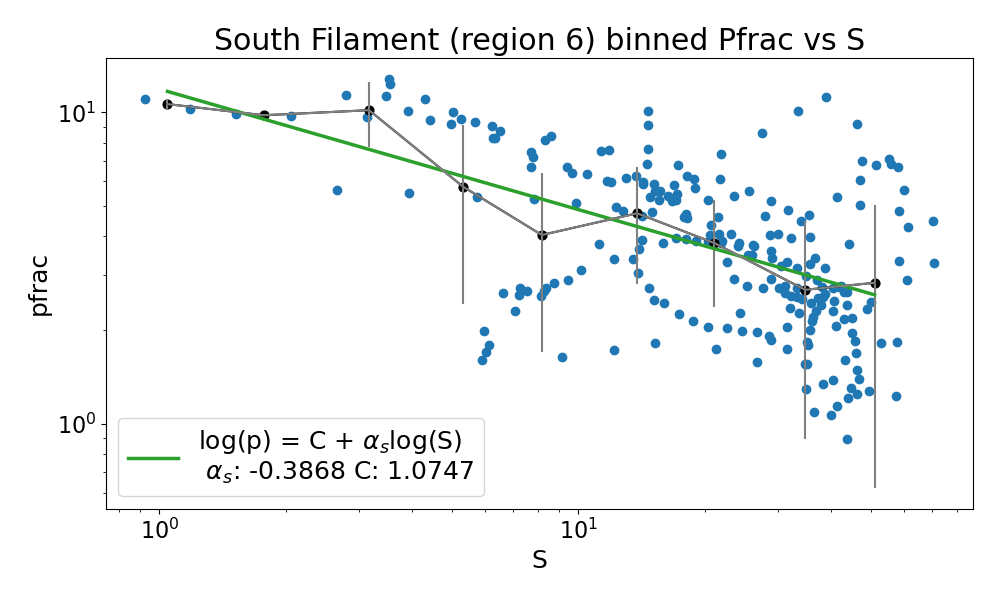

70064


In [22]:
####### changing data to array
s_SouthFilament_array = s_SouthFilament.data.flatten()
p_SouthFilament_array = p_SouthFilament.data.flatten()
I_SouthFilament_array = I_SouthFilament.data.flatten()
nh2_SouthFilament_array = nh2_SouthFilament.data.flatten()
micron8_SouthFilament_array = micron8_SouthFilament.data.flatten()

######## making the data points independent
s_SouthFilament_array_ind = s_SouthFilament_array.copy()
s_SouthFilament_array_ind = s_SouthFilament_array_ind[::4]
p_SouthFilament_array_ind = p_SouthFilament_array.copy()
p_SouthFilament_array_ind = p_SouthFilament_array_ind[::4]
I_SouthFilament_array_ind = I_SouthFilament_array.copy()
I_SouthFilament_array_ind = I_SouthFilament_array_ind[::4]
nh2_SouthFilament_array_ind = nh2_SouthFilament_array.copy()
nh2_SouthFilament_array_ind = nh2_SouthFilament_array_ind[::4]
micron8_SouthFilament_array_ind = micron8_SouthFilament_array.copy()
micron8_SouthFilament_array_ind = micron8_SouthFilament_array_ind[::4]


######## taking log10 of the data
log_s_fil = np.log10(s_SouthFilament_array_ind)
log_p_fil = np.log10(p_SouthFilament_array_ind)
log_I_fil = np.log10(I_SouthFilament_array_ind)
log_nh2_fil = np.log10(nh2_SouthFilament_array_ind)
log_8micron_fil = np.log10(micron8_SouthFilament_array_ind)



plt.figure(figsize=(10,6))
plt.scatter(nh2_SouthFilament_array_ind,p_SouthFilament_array_ind)
binning_equal_width(np.log10(nh2_SouthFilament_array_ind),np.log10(p_SouthFilament_array_ind),10)
param,x,y = binning_equal_width_fits(np.log10(nh2_SouthFilament_array_ind),np.log10(p_SouthFilament_array_ind),10)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('South Filament (region 6) binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.yticks([1e0,1e1])
# plt.xticks(np.array([1e22,1e23,1e24]))
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(s_SouthFilament_array_ind,p_SouthFilament_array_ind)
binning_equal_width(np.log10(s_SouthFilament_array_ind),np.log10(p_SouthFilament_array_ind),10)
param,x,y = binning_equal_width_fits(np.log10(s_SouthFilament_array_ind),np.log10(p_SouthFilament_array_ind),10)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('South Filament (region 6) binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()

print(nh2_SouthFilament_array.size)


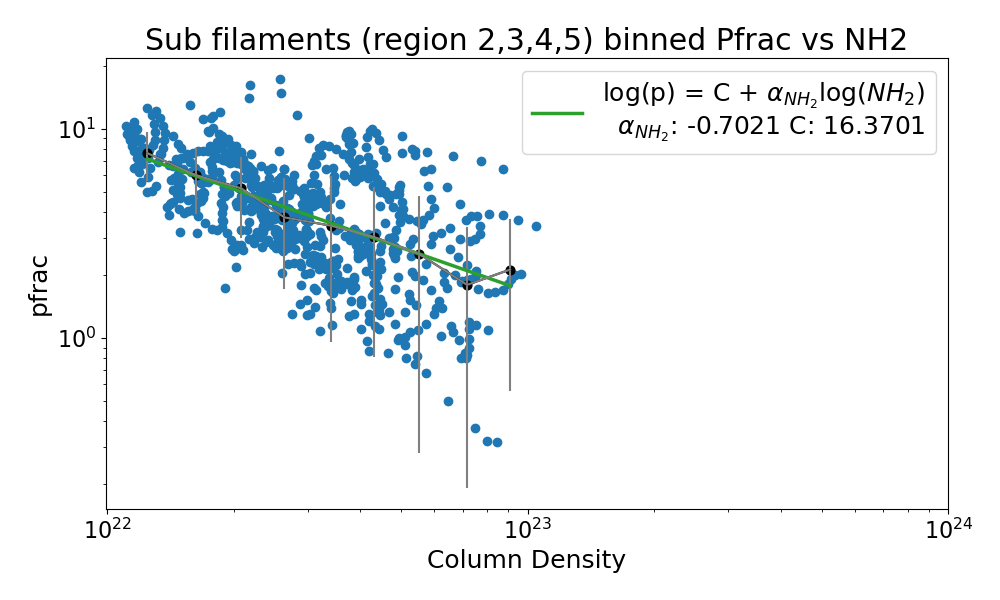

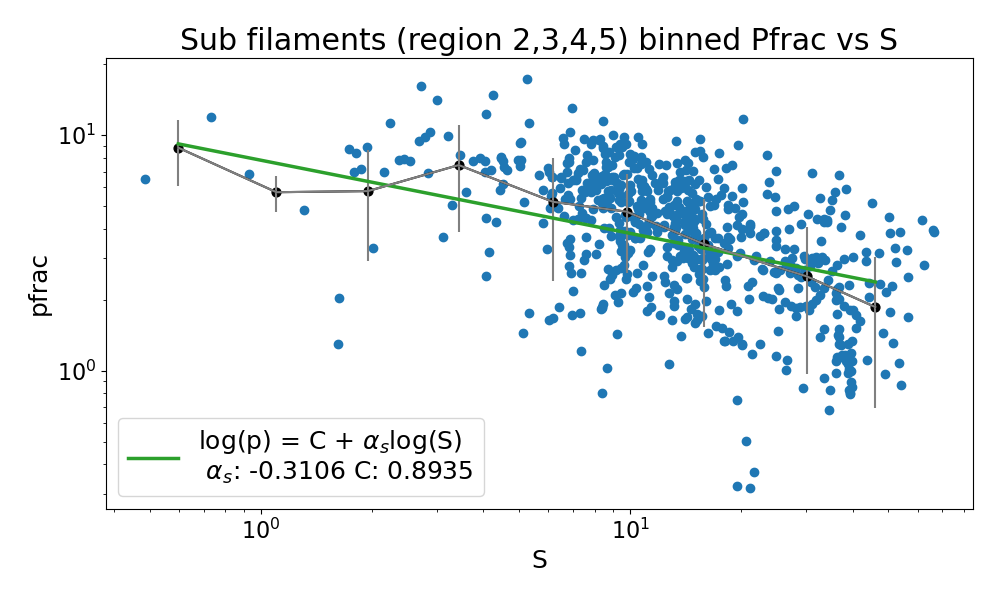

In [23]:
####### changing data to array
s_rest_array = s_rest.data.flatten()
p_rest_array = p_rest.data.flatten()
I_rest_array = I_rest.data.flatten()
nh2_rest_array = nh2_rest.data.flatten()
micron8_rest_array = micron8_rest.data.flatten()

######## making the data points independent
s_rest_array_ind = s_rest_array.copy()
s_rest_array_ind = s_rest_array_ind[::4]
p_rest_array_ind = p_rest_array.copy()
p_rest_array_ind = p_rest_array_ind[::4]
I_rest_array_ind = I_rest_array.copy()
I_rest_array_ind = I_rest_array_ind[::4]
nh2_rest_array_ind = nh2_rest_array.copy()
nh2_rest_array_ind = nh2_rest_array_ind[::4]
micron8_rest_array_ind = micron8_rest_array.copy()
micron8_rest_array_ind = micron8_rest_array_ind[::4]


######## taking log10 of the data
log_s_fil = np.log10(s_rest_array_ind)
log_p_fil = np.log10(p_rest_array_ind)
log_I_fil = np.log10(I_rest_array_ind)
log_nh2_fil = np.log10(nh2_rest_array_ind)
log_8micron_fil = np.log10(micron8_rest_array_ind)


######## binning data

plt.figure(figsize=(10,6))
plt.scatter(nh2_rest_array_ind,p_rest_array_ind)
binning_equal_width(np.log10(nh2_rest_array_ind),np.log10(p_rest_array_ind),10)
param,x,y = binning_equal_width_fits(np.log10(nh2_rest_array_ind),np.log10(p_rest_array_ind),10)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('Sub filaments (region 2,3,4,5) binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.yticks([1e0,1e1])
plt.xticks(np.array([1e22,1e23,1e24]))
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(s_rest_array_ind,p_rest_array_ind)
binning_equal_width(np.log10(s_rest_array_ind),np.log10(p_rest_array_ind),10)
param,x,y = binning_equal_width_fits(np.log10(s_rest_array_ind),np.log10(p_rest_array_ind),10)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('Sub filaments (region 2,3,4,5) binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()





In [ ]:
def lin_fit(x, a, b):
    return a + b*x


s_rest_array = s_rest.data.flatten()
p_rest_array = p_rest.data.flatten()
nh2_rest_array = nh2_rest.data.flatten()


log_s = np.log(s_rest_array)
log_p = np.log(p_rest_array)
log_nh2 = np.log(nh2_rest_array)

df_log = pd.DataFrame({'logp': log_p,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)

def curve_fitting(x):
    param, param_cov = curve_fit(lin_fit,(x[:,1]),x[:,0])
    return param

nh2_SouthFilament_array = nh2_SouthFilament.data.flatten()
df = pd.DataFrame({'log_south':nh2_SouthFilament_array})
df = df.dropna()
# print(df.info())


bootresult = bootstrap(bootarr,bootnum = 10000, samples = 898,bootfunc=curve_fitting)
print('alpha_nh2',(bootresult[:,1]))
print(np.max(bootresult[:,1]))
print(np.min(bootresult[:,1]))


# print('error in alpha_nh2',np.mean(bootresult[:,2]))

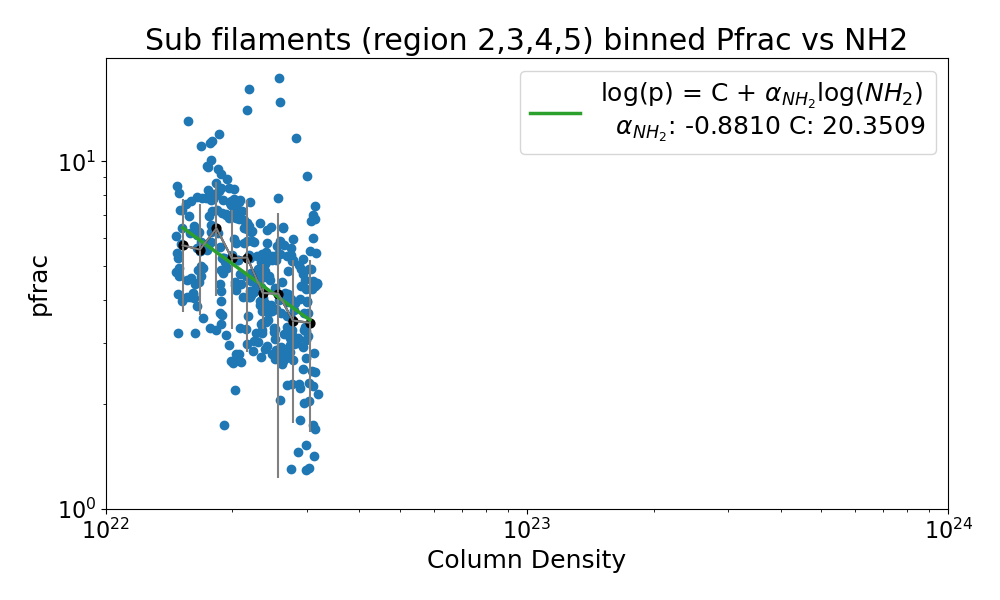

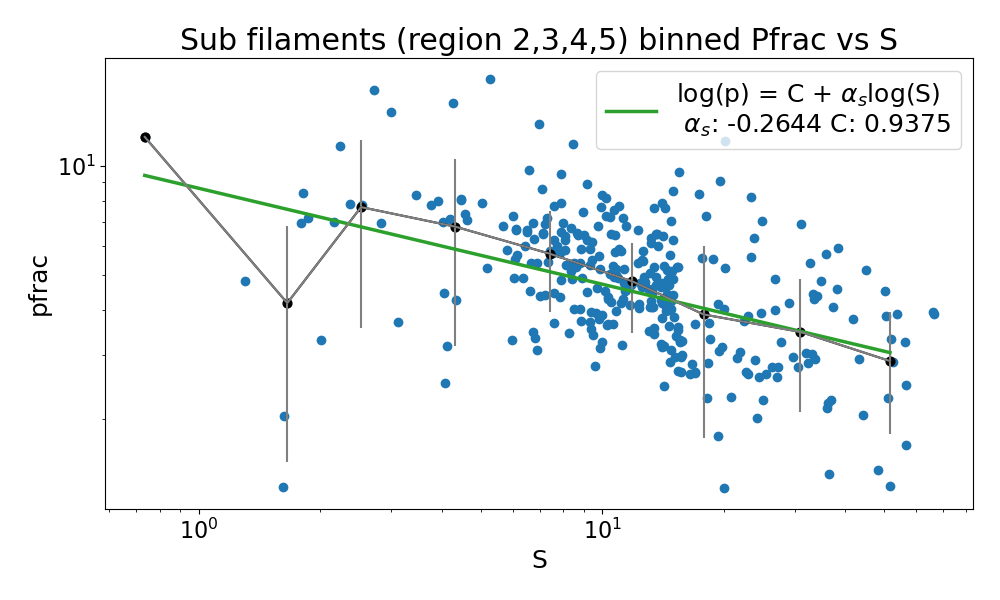

In [24]:
Selector = nh2_rest.data > np.nanmax(nh2_SouthFilament.data)
nh2_rest.data[Selector] = np.nan
p_rest.data[Selector] = np.nan
s_rest.data[Selector] = np.nan

Selector = nh2_rest.data < np.nanmin(nh2_SouthFilament.data)
nh2_rest.data[Selector] = np.nan
p_rest.data[Selector] = np.nan
s_rest.data[Selector] = np.nan


####### changing data to array
p_rest_array = p_rest.data.flatten()
nh2_rest_array = nh2_rest.data.flatten()

######## making the data points independent

p_rest_array_ind = p_rest_array.copy()
p_rest_array_ind = p_rest_array_ind[::4]
nh2_rest_array_ind = nh2_rest_array.copy()
nh2_rest_array_ind = nh2_rest_array_ind[::4]



######## taking log10 of the data

log_p_fil = np.log10(p_rest_array_ind)
log_nh2_fil = np.log10(nh2_rest_array_ind)
log_s_fil = np.log10(s_rest_array_ind)


plt.figure(figsize=(10,6))
plt.scatter(nh2_rest_array_ind,p_rest_array_ind)
binning_equal_width(np.log10(nh2_rest_array_ind),np.log10(p_rest_array_ind),10)
param,x,y = binning_equal_width_fits(np.log10(nh2_rest_array_ind),np.log10(p_rest_array_ind),10)
label_temp = r'log(p) = C + $\alpha${nh2}log($NH_2$){linebreak}  $\alpha${nh2}: {alpha_nh2:.4f} C: {C:.4f}'.format(nh2 = r'$_{NH_2}$',alpha_nh2 = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('Sub filaments (region 2,3,4,5) binned Pfrac vs NH2')
plt.xscale('log')
plt.yscale('log')
plt.yticks([1e0,1e1])
plt.xticks(np.array([1e22,1e23,1e24]))
plt.xlabel('Column Density')
plt.ylabel('pfrac')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.scatter(s_rest_array_ind,p_rest_array_ind)
binning_equal_width(np.log10(s_rest_array_ind),np.log10(p_rest_array_ind),10)
param,x,y = binning_equal_width_fits(np.log10(s_rest_array_ind),np.log10(p_rest_array_ind),10)
label_temp = r'log(p) = C + $\alpha_s$log(S){linebreak} $\alpha_s$: {alpha_s:.4f} C: {C:.04f}'.format(alpha_s = param[1],C = param[0],linebreak='\n')
plt.plot(x,y,'tab:green',linewidth = 2.5,label = label_temp)
plt.title('Sub filaments (region 2,3,4,5) binned Pfrac vs S')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('S')
plt.ylabel('pfrac')
plt.tight_layout()
plt.legend()
plt.show()



In [26]:
def lin_fit(x, a, b):
    return a + b*x


s_rest_array = s_rest.data.flatten()
p_rest_array = p_rest.data.flatten()
nh2_rest_array = nh2_rest.data.flatten()


log_s = np.log(s_rest_array)
log_p = np.log(p_rest_array)
log_nh2 = np.log(nh2_rest_array)

df_log = pd.DataFrame({'logp': log_p,'lognh2':log_nh2})
df_log = df_log.dropna()
bootarr = np.array(df_log)

def curve_fitting(x):
    param, param_cov = curve_fit(lin_fit,(x[:,1]),x[:,0])
    return param

nh2_SouthFilament_array = nh2_SouthFilament.data.flatten()
df = pd.DataFrame({'log_south':nh2_SouthFilament_array})
df = df.dropna()
# print(df.info())


bootresult = bootstrap(bootarr,bootnum = 10000, samples = 898,bootfunc=curve_fitting)
print('alpha_nh2',(bootresult[:,1]))
print(np.max(bootresult[:,1]))
print(np.min(bootresult[:,1]))


# print('error in alpha_nh2',np.mean(bootresult[:,2]))

alpha_nh2 [-0.92429694 -0.90221086 -0.89529184 ... -0.96965871 -0.99425353
 -1.14711515]
-0.7840102855025014
-1.264120152176753
